In [77]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
import math
from datetime import date, timedelta, datetime
import time
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import xlsxwriter
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
start_time = time.perf_counter()

In [78]:
import glob
import os

# Define the folder path containing the CSV files
folder_path = 'factor_nav_21_4_2025'

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Create an empty DataFrame to store the merged result
merged_df = None

# Process each CSV file
for file in csv_files:
    # Extract the factor/strategy name from the filename
    file_name = os.path.splitext(os.path.basename(file))[0]
    
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Drop 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # Convert 'Date' column to datetime
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    # Get the name of the factor/strategy column (the column that's not 'Date')
    factor_col = [col for col in df.columns if col != 'Date'][0]
    
    # Create a simple DataFrame with just Date and the factor column
    simple_df = df[['Date', factor_col]]
    
    # If this is the first file, initialize the merged DataFrame
    if merged_df is None:
        merged_df = simple_df
    else:
        # Merge with the existing DataFrame
        merged_df = pd.merge(merged_df, simple_df, on='Date', how='outer')

# Now load the benchmark data
df1 = pd.read_excel('latest size data.xlsx')
df1 = df1[['Date', 'NIFTY500']]
df1['Date'] = pd.to_datetime(df1['Date'], format='%d-%m-%Y')
df1['Date'] = df1['Date'].dt.strftime('%Y-%m-%d')
df1['Date'] = pd.to_datetime(df1['Date'])

# Merge with the benchmark data
merged_df = pd.merge(merged_df, df1, on='Date', how='inner')

# Set 'Date' as the index
merged_df.set_index('Date', inplace=True)

# Display the column names to confirm no duplicates
print("Final columns:", merged_df.columns.tolist())
print(f"Shape of final dataframe: {merged_df.shape}")

Final columns: ['ThemeGrowthConsol', 'SectorAM', 'UltraShortAM', 'ValueYieldNoPeg', 'QualityAnnual', 'LowVol', 'LongAM', 'SectorHighBeta', 'ThemeLTMA', 'SectorAvgVol', 'ThemeAvgVol', 'ThemeShortAM', 'SectorValueYield', 'ShortSectorAM', 'EM', 'LTM_x', 'TrendMR', 'SectorLowVol', 'ThemeEM', 'MidSectorAM', 'ThemeValueYield', 'ThemeLTM', 'LongSectorAM', 'SectorGrowthConsol', 'SectorGrowth', 'Growth', 'SectorDownVol', 'LTMA', 'ValueYield', 'QualityQuarterConsol', 'ValueABSExDiv', 'SectorValuePrice', 'ThemeHighBeta', 'ThemeDownVol', 'QualityQuarter', 'DownVol', 'ThemeValuePrice', 'ValuePrice', 'LTM_y', 'AM', 'ThemeAM', 'AntiTrendMR', 'ValueABS', 'GrowthConsol', 'ThemeGrowth', 'ThemeLowVol', 'Dividend', 'UltraShortSectorAM', 'ThemeLongAM', 'QualityAnnualConsol', 'AvgVol', 'ThemeUltraShortAM', 'ValueYieldExDiv', 'ShiftedAM', 'SectorLowBeta', 'SectorValueABS', 'LowBeta', 'ShortAM', 'HighBeta', 'ValueABSNoPeg', 'MidAM', 'ThemeValueABS', 'ThemeMidAM', 'ThemeLowBeta', 'NIFTY500']
Shape of final dat

In [41]:
def calculate_cross_sectional_zscore(df, metric_columns, inverse_columns=[]):
    """
    Calculate z-score across factors for given metric columns on each day,
    inverting specified columns so that lower values correspond to higher z-scores.
    """
    adjusted_df = df.copy()
    
    # Invert specified columns for correct z-score scaling
    for col in inverse_columns:
        adjusted_df[col] = -adjusted_df[col]
    
    return (adjusted_df[metric_columns] - adjusted_df[metric_columns].mean(axis=1).values[:, None]) / \
           adjusted_df[metric_columns].std(axis=1).values[:, None]

def calculate_metrics(df, benchmark_col='NIFTY500', lookback_days=[63, 22]):
    """
    Calculate various metrics for factor analysis and their daily cross-sectional z-scores
    for multiple lookback periods.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing price data for factors and benchmark
    benchmark_col : str
        Column name for the benchmark
    lookback_days : list
        List of lookback periods to calculate metrics for
    """
    metrics_df = pd.DataFrame(index=df.index)
    
    # Get factor columns (exclude benchmark)
    factor_cols = [col for col in df.columns if col != benchmark_col]
    
    # Calculate returns
    returns = df.pct_change()
    log_returns = np.log1p(returns)
    
    # Process for each lookback period
    for period in lookback_days:
        # Dictionary to store columns for each metric type and period
        metric_columns = {
            f'benchmark_ratio_{period}d': [],
            f'alpha_{period}d': [],
            f'vol_benchmark_ratio_{period}d': [],
            f'sharpe_{period}d': []
        }
        
        # Calculate rolling returns for this period
        rolling_log_returns = log_returns.rolling(window=period).sum()
        rolling_returns = np.expm1(rolling_log_returns)
        
        # 1. Rolling returns to benchmark rolling returns ratio
        for col in factor_cols:
            col_name = f'{col}_to_benchmark_ratio_{period}d'
            metrics_df[col_name] = rolling_returns[col] / rolling_returns[benchmark_col]
            metric_columns[f'benchmark_ratio_{period}d'].append(col_name)
        
        # 2. Price to benchmark alpha (rolling)
        for col in factor_cols:
            col_name = f'{col}_alpha_{period}d'
            metrics_df[col_name] = rolling_returns[col] - rolling_returns[benchmark_col]
            metric_columns[f'alpha_{period}d'].append(col_name)
        
        # 3. Volatility calculations
        def annualized_vol(series, lookback):
            return np.sqrt(252) * series.rolling(window=lookback).std()
        
        # Calculate volatilities
        vols = pd.DataFrame()
        for col in factor_cols + [benchmark_col]:
            vols[col] = annualized_vol(returns[col], period)
        
        # Vol to benchmark vol ratio
        for col in factor_cols:
            col_name = f'{col}_vol_to_benchmark_ratio_{period}d'
            metrics_df[col_name] = vols[col] / vols[benchmark_col]
            metric_columns[f'vol_benchmark_ratio_{period}d'].append(col_name)
        
        # 4. Calculate Sharpe ratio for all factors AND benchmark (returns/vol)
        benchmark_col_name = f'{benchmark_col}_sharpe_{period}d'
        metrics_df[benchmark_col_name] = np.where(
            vols[benchmark_col] == 0,
            np.nan,
            rolling_returns[benchmark_col] / vols[benchmark_col]
        )
        
        for col in factor_cols:
            col_name = f'{col}_sharpe_{period}d'
            metrics_df[col_name] = np.where(
                vols[col] == 0,
                np.nan,
                rolling_returns[col] / vols[col]
            )
            metric_columns[f'sharpe_{period}d'].append(col_name)
        
        # Add benchmark to the sharpe list to include in cross-sectional analysis
        metric_columns[f'sharpe_{period}d'].append(benchmark_col_name)
        
        # Calculate cross-sectional z-scores with inversion for vol-related metrics
        for metric_type, columns in metric_columns.items():
            inverse_cols = columns if 'vol_benchmark_ratio' in metric_type else []
            zscore_df = calculate_cross_sectional_zscore(metrics_df, columns, inverse_columns=inverse_cols)
            for col, zscore_col in zip(columns, zscore_df.columns):
                metrics_df[f'{col}_zscore'] = zscore_df[zscore_col]
    
    return metrics_df

def format_metrics_report(metrics_df, date=None, include_zscores=True, lookback_days=[63, 22]):
    """
    Create a formatted report of metrics for a specific date.
    
    Parameters:
    -----------
    metrics_df : pandas.DataFrame
        DataFrame containing calculated metrics
    date : datetime or None
        Date to generate report for, defaults to latest date in metrics_df
    include_zscores : bool
        Whether to include z-scores in the report
    lookback_days : list
        List of lookback periods used in the metrics
    """
    if date is None:
        date = metrics_df.index[-1]
        
    daily_data = metrics_df.loc[date]
    
    report = f"Factor Metrics Report for {date.strftime('%Y-%m-%d')}\n\n"
    
    # Group metrics by factor
    factor_metrics = {}
    for col in daily_data.index:
        if not include_zscores and '_zscore' in col:
            continue
            
        parts = col.split('_')
        factor = parts[0]
        if factor not in factor_metrics:
            factor_metrics[factor] = []
        factor_metrics[factor].append((col, daily_data[col]))
    
    # Format report by factor and period
    for factor, metrics in sorted(factor_metrics.items()):
        report += f"{factor}:\n"
        
        # Group metrics by lookback period
        for period in lookback_days:
            report += f"  {period}-day metrics:\n"
            period_metrics = [(name, val) for name, val in metrics if f'_{period}d' in name]
            
            for metric_name, value in sorted(period_metrics):
                # Extract just the metric type without factor name and period
                name_parts = metric_name.split('_')
                if f'{period}d' in name_parts[-1]:
                    metric_parts = name_parts[1:-1]
                else:
                    metric_parts = name_parts[1:]
                    if 'zscore' in metric_parts:
                        metric_parts.remove('zscore')
                    metric_parts = [p for p in metric_parts if p != f'{period}d']
                    
                metric_type = '_'.join(metric_parts)
                report += f"    {metric_type}: {value:.4f}\n"
            report += "\n"
    
    return report

# Example usage (uncomment to run):
metrics_df = calculate_metrics(merged_df, lookback_days=[63, 22])
report = format_metrics_report(metrics_df, include_zscores=True, lookback_days=[63, 22])
print(report)

Factor Metrics Report for 2025-04-17

AM:
  63-day metrics:
    alpha: -0.1345
    alpha: -1.9633
    sharpe: -0.3718
    sharpe: -1.8992
    to_benchmark_ratio: -5.5228
    to_benchmark_ratio: -1.9633
    vol_to_benchmark_ratio: 1.6941
    vol_to_benchmark_ratio: -0.6737

  22-day metrics:
    alpha: 0.0015
    alpha: -0.7730
    sharpe: 0.2667
    sharpe: -0.7071
    to_benchmark_ratio: 1.0208
    to_benchmark_ratio: -0.7730
    vol_to_benchmark_ratio: 1.2004
    vol_to_benchmark_ratio: 0.0408

AntiTrendMR:
  63-day metrics:
    alpha: 0.0256
    alpha: 1.0776
    sharpe: 0.1661
    sharpe: 0.9712
    to_benchmark_ratio: 2.2392
    to_benchmark_ratio: 1.0776
    vol_to_benchmark_ratio: 1.5374
    vol_to_benchmark_ratio: -0.2694

  22-day metrics:
    alpha: 0.0355
    alpha: 0.7613
    sharpe: 0.3055
    sharpe: -0.3582
    to_benchmark_ratio: 1.5069
    to_benchmark_ratio: 0.7613
    vol_to_benchmark_ratio: 1.5473
    vol_to_benchmark_ratio: -1.0727

AvgVol:
  63-day metrics:
    al

In [42]:
metrics_df

,ThemeGrowthConsol_to_benchmark_ratio_63d,SectorAM_to_benchmark_ratio_63d,UltraShortAM_to_benchmark_ratio_63d,ValueYieldNoPeg_to_benchmark_ratio_63d,QualityAnnual_to_benchmark_ratio_63d,LowVol_to_benchmark_ratio_63d,LongAM_to_benchmark_ratio_63d,SectorHighBeta_to_benchmark_ratio_63d,ThemeLTMA_to_benchmark_ratio_63d,SectorAvgVol_to_benchmark_ratio_63d,...,SectorValueABS_sharpe_22d_zscore,LowBeta_sharpe_22d_zscore,ShortAM_sharpe_22d_zscore,HighBeta_sharpe_22d_zscore,ValueABSNoPeg_sharpe_22d_zscore,MidAM_sharpe_22d_zscore,ThemeValueABS_sharpe_22d_zscore,ThemeMidAM_sharpe_22d_zscore,ThemeLowBeta_sharpe_22d_zscore,NIFTY500_sharpe_22d_zscore
Date,,,,,,,,,,,,,,,,,,,,,
2006-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-09,2.064452,1.491451,3.100313,1.184888,1.152259,0.477145,2.759302,1.045577,2.389345,0.751008,...,0.747663,1.076025,-0.467157,-0.775697,-0.857068,-0.607997,-1.552349,0.399591,2.057110,-0.404963
2025-04-11,2.267241,1.511451,3.685363,1.155610,1.165018,0.523524,3.087287,0.859989,2.656401,0.615905,...,0.665612,1.007565,-0.462777,-1.511059,-1.030780,-0.428931,-2.226204,0.143299,2.424235,-0.263074
2025-04-15,3.200503,1.768882,5.832660,1.034189,1.541223,0.491516,4.517488,0.295839,3.790583,0.646914,...,0.725867,0.891286,-0.361188,-1.223371,-0.912236,-0.863175,-2.276808,0.343512,1.732677,-0.359340


In [43]:
# This step remains the same
prefixes = ['LTM', 'ValueYield', 'ValueABS', 'Growth',
       'QualityAnnual', 'QualityQuarter', 'EM', 'Dividend', 'LTMA', 'LowVol',
       'DownVol', 'AvgVol', 'SectorLowVol', 'SectorDownVol', 'SectorAvgVol',
       'AM', 'SectorAM', 'UltraShortAM', 'UltraShortSectorAM', 'ShortAM',
       'ShortSectorAM', 'ValueYieldNoPeg', 'ValueABSNoPeg', 'ValueYieldExDiv',
       'ValueABSExDiv', 'MidAM', 'MidSectorAM', 'LongAM', 'LongSectorAM',
       'HighBeta', 'LowBeta', 'TrendMR', 'AntiTrendMR', 'ShiftedAM',
       'SectorHighBeta', 'SectorLowBeta', 'ThemeHighBeta', 'ThemeLowBeta',
       'ValuePrice', 'SectorValueYield', 'ThemeValueYield', 'SectorValueABS',
       'ThemeValueABS', 'SectorValuePrice', 'ThemeValuePrice', 'GrowthConsol',
       'QualityAnnualConsol', 'QualityQuarterConsol', 'SectorGrowth',
       'SectorGrowthConsol', 'ThemeGrowth', 'ThemeGrowthConsol', 'ThemeAM',
       'ThemeUltraShortAM', 'ThemeShortAM', 'ThemeMidAM', 'ThemeLongAM',
       'ThemeLTM', 'ThemeLTMA', 'ThemeEM', 'ThemeLowVol', 'ThemeDownVol',
       'ThemeAvgVol', 'NIFTY500']

# Select columns that end with '_zscore'
df_zscore = metrics_df.filter(regex='_zscore$')

# Initialize dictionaries to store z-score columns grouped by prefix and period
prefixes_zscores_63d = {prefix: [] for prefix in prefixes}
prefixes_zscores_22d = {prefix: [] for prefix in prefixes}

# Identify columns corresponding to each prefix and separate by period
for col in df_zscore.columns:
    if col.endswith('_zscore'):
        for prefix in prefixes:
            if prefix in col:
                if '_63d_' in col:
                    prefixes_zscores_63d[prefix].append(col)
                elif '_22d_' in col:
                    prefixes_zscores_22d[prefix].append(col)

# Compute the average z-score for each prefix for 63-day period
df_avg_zscores_63d = pd.DataFrame({
    f"{prefix}_63d": df_zscore[cols].mean(axis=1) 
    for prefix, cols in prefixes_zscores_63d.items() if cols
})

# Compute the average z-score for each prefix for 22-day period
df_avg_zscores_22d = pd.DataFrame({
    f"{prefix}_22d": df_zscore[cols].mean(axis=1) 
    for prefix, cols in prefixes_zscores_22d.items() if cols
})

# Combine both periods' average z-scores into a single DataFrame
df_avg_zscores_by_period = pd.concat([df_avg_zscores_63d, df_avg_zscores_22d], axis=1)

# Optional: Calculate a combined average across both periods
df_avg_zscores_combined = pd.DataFrame({
    prefix: df_avg_zscores_by_period[[f"{prefix}_63d", f"{prefix}_22d"]].mean(axis=1)
    for prefix in prefixes if f"{prefix}_63d" in df_avg_zscores_by_period.columns and f"{prefix}_22d" in df_avg_zscores_by_period.columns
})

# Print number of z-score metrics found for each prefix and period
print("Number of z-score metrics by prefix and period:")
for prefix in prefixes:
    print(f"{prefix}: 63-day metrics: {len(prefixes_zscores_63d[prefix])}, 22-day metrics: {len(prefixes_zscores_22d[prefix])}")

Number of z-score metrics by prefix and period:
LTM: 63-day metrics: 20, 22-day metrics: 20
ValueYield: 63-day metrics: 20, 22-day metrics: 20
ValueABS: 63-day metrics: 20, 22-day metrics: 20
Growth: 63-day metrics: 24, 22-day metrics: 24
QualityAnnual: 63-day metrics: 8, 22-day metrics: 8
QualityQuarter: 63-day metrics: 8, 22-day metrics: 8
EM: 63-day metrics: 8, 22-day metrics: 8
Dividend: 63-day metrics: 4, 22-day metrics: 4
LTMA: 63-day metrics: 8, 22-day metrics: 8
LowVol: 63-day metrics: 12, 22-day metrics: 12
DownVol: 63-day metrics: 12, 22-day metrics: 12
AvgVol: 63-day metrics: 12, 22-day metrics: 12
SectorLowVol: 63-day metrics: 4, 22-day metrics: 4
SectorDownVol: 63-day metrics: 4, 22-day metrics: 4
SectorAvgVol: 63-day metrics: 4, 22-day metrics: 4
AM: 63-day metrics: 64, 22-day metrics: 64
SectorAM: 63-day metrics: 20, 22-day metrics: 20
UltraShortAM: 63-day metrics: 8, 22-day metrics: 8
UltraShortSectorAM: 63-day metrics: 4, 22-day metrics: 4
ShortAM: 63-day metrics: 16, 

In [44]:
df_avg_zscores_combined

,LTM,ValueYield,ValueABS,Growth,QualityAnnual,QualityQuarter,EM,Dividend,LTMA,LowVol,...,ThemeShortAM,ThemeMidAM,ThemeLongAM,ThemeLTM,ThemeLTMA,ThemeEM,ThemeLowVol,ThemeDownVol,ThemeAvgVol,NIFTY500
Date,,,,,,,,,,,,,,,,,,,,,
2006-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-09,-0.575549,0.045538,0.031916,-0.143690,0.053543,-0.053915,-0.233760,0.183814,-0.489543,0.620762,...,-0.134161,0.166780,-0.096830,-0.502031,-0.412979,0.222770,0.617725,0.484126,0.620922,-0.165850
2025-04-11,-0.720804,0.002721,-0.210921,0.015223,0.015487,-0.222607,-0.143641,0.200286,-0.654808,0.767125,...,-0.168715,0.224632,-0.012996,-0.940263,-0.798868,0.688567,0.886210,0.599709,0.841841,-0.014309
2025-04-15,-0.562822,0.032704,-0.155326,0.148448,0.052868,-0.427962,-0.267587,0.111780,-0.561090,0.607599,...,-0.103807,0.324297,0.073476,-0.777995,-0.655630,0.499398,0.795211,0.328344,0.747713,0.089027


In [45]:
#### Market Higher Normalized Zscore Weights
factor_groups = {
    "Momentum": ['AM', 'LongAM', 'MidAM', 'EM', 'ShiftedAM', 'HighBeta'],
    "Theme Momentum": ['SectorAM', 'ThemeAM', 'ThemeLongAM', 'ThemeMidAM', 'ThemeEM', 'ThemeLTM'],
    "Volatility": ['AvgVol', 'DownVol', 'LowBeta', 'LowVol'],
    "Theme Volatility": ['SectorDownVol', 'SectorLowBeta', 'SectorLowVol', 'ThemeDownVol', 'ThemeLowBeta', 'ThemeLowVol'],
    "Growth": ['Growth', 'GrowthConsol'],
    "Quality": ['QualityAnnualConsol', 'QualityQuarterConsol'],
    "Value": ['ValueYield', 'ValueYieldExDiv', 'Value_ABS']
}

# #### Market Higher Normalized Zscore Weights New
# factor_groups = {
#     "Momentum": ['ShiftedAM'],
#     "Theme Momentum": ['SectorAM'],
#     "Volatility": ['LowVol'],
#     "Theme Volatility": ['SectorLowVol'],
#     "Growth": ['Growth'],
#     "Quality": ['QualityQuarterConsol'],
#     "Value": ['Value_ABS']
# }

def allocate_weights_by_groups(df, factor_groups):
    """
    Allocate weights only to factor groups where at least one factor's z-score 
    is greater than the Nifty 500's z-score. After filtering, apply normalization
    to z-scores before calculating weights.
    
    Args:
        df: DataFrame with dates as index and factors as columns, including 'Nifty500'
        factor_groups: Dictionary mapping group names to lists of factor names
        
    Returns:
        dict: Dictionary containing weight DataFrames for each method
    """
    # Ensure we're working with a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Get unique dates from index
    dates = df_copy.index.unique()
    group_names = list(factor_groups.keys())
    
    # Initialize DataFrames for weights
    max_weights_df = pd.DataFrame(index=dates, columns=group_names, dtype=float).fillna(0)
    top2_weights_df = pd.DataFrame(index=dates, columns=group_names, dtype=float).fillna(0)
    all_weights_df = pd.DataFrame(index=dates, columns=group_names, dtype=float).fillna(0)
    exp_weights_df = pd.DataFrame(index=dates, columns=group_names, dtype=float).fillna(0)
    
    # Check if Nifty500 is in the columns
    nifty_column = 'NIFTY500'
    if 'NIFTY500' in df_copy.columns:
        nifty_column = 'NIFTY500'
    elif 'NIFTY500' not in df_copy.columns:
        print(f"Warning: Nifty500 column not found. Available columns: {df_copy.columns.tolist()}")
        return {
            "max_weights": max_weights_df,
            "top2_weights": top2_weights_df,
            "all_weights": all_weights_df,
            "exp_weights": exp_weights_df
        }
    
    # Process each date
    for date in dates:
        try:
            # Get data for this date
            date_data = df_copy.loc[date]
            
            # Handle case where date_data is a Series (single row)
            if isinstance(date_data, pd.Series):
                nifty500_zscore = date_data[nifty_column]
            else:
                # Handle case where date_data is a DataFrame (multiple rows)
                nifty500_zscore = date_data[nifty_column].iloc[0]
            
            # Skip if Nifty500 z-score is NaN
            if pd.isna(nifty500_zscore):
                print(f"Skipping date {date} - Nifty z-score is NaN")
                continue
            
            # Dictionary to store qualifying factors for each group
            qualifying_groups = {}
            
            # First pass: identify which groups have factors that beat the market
            for group_name, factors in factor_groups.items():
                # Get valid factors (those that exist in the columns)
                valid_factors = [f for f in factors if f in df_copy.columns]
                
                if not valid_factors:
                    continue  # Skip if no valid factors for this group
                
                # Get z-scores for valid factors for this date
                if isinstance(date_data, pd.Series):
                    group_scores = date_data[valid_factors]
                else:
                    group_scores = date_data[valid_factors].iloc[0]
                
                # Drop any NaN values
                group_scores = group_scores.dropna()
                
                if group_scores.empty:
                    continue  # Skip if all values are NaN
                
                # Filter factors with z-scores > Nifty500
                qualifying_factors = group_scores[group_scores > nifty500_zscore]
                
                if not qualifying_factors.empty:
                    # Apply normalization transformation to qualifying factors
                    normalized_factors = qualifying_factors.copy()
                    
                    # Apply normalization: if z >= 0: 1 + z, else: (1 - z)^-1
                    normalized_factors = np.where(
                        normalized_factors >= 0,
                        1 + normalized_factors,
                        (1 - normalized_factors) ** -1
                    )
                    
                    # Convert back to Series with same index as qualifying_factors
                    normalized_factors = pd.Series(normalized_factors, index=qualifying_factors.index)
                    
                    qualifying_groups[group_name] = normalized_factors
            
            # Skip further processing if no qualifying groups
            if not qualifying_groups:
                print(f"No qualifying groups for date {date}")
                continue
                
            # Calculate sum of max scores across all qualifying groups for normalization
            max_scores = pd.Series({group: scores.max() for group, scores in qualifying_groups.items()})
            max_score_sum = max_scores.sum()
            
            # Calculate sum of top2 scores across all qualifying groups
            top2_scores = pd.Series({
                group: np.mean(sorted(scores.values, reverse=True)[:min(2, len(scores))])
                for group, scores in qualifying_groups.items()
            })
            top2_score_sum = top2_scores.sum()
            
            # Calculate sum of average scores across all qualifying groups
            avg_scores = pd.Series({group: scores.mean() for group, scores in qualifying_groups.items()})
            avg_score_sum = avg_scores.sum()
            
            # Calculate exponential scores
            try:
                exp_scores = {}
                for group, scores in qualifying_groups.items():
                    exp_scores[group] = np.mean(np.exp(scores))
                exp_score_sum = sum(exp_scores.values())
            except (OverflowError, FloatingPointError):
                # Normalize to prevent overflow
                all_scores = pd.concat([scores for scores in qualifying_groups.values()])
                max_all = all_scores.max()
                
                exp_scores = {}
                for group, scores in qualifying_groups.items():
                    exp_scores[group] = np.mean(np.exp(scores - max_all))
                exp_score_sum = sum(exp_scores.values())
            
            # Second pass: calculate weights for each group
            if max_score_sum > 0:
                for group_name in qualifying_groups:
                    # Method 1: Max weight
                    max_weights_df.loc[date, group_name] = max_scores[group_name] / max_score_sum
                    
                    # Method 2: Top2 weight
                    if top2_score_sum > 0:
                        top2_weights_df.loc[date, group_name] = top2_scores[group_name] / top2_score_sum
                    
                    # Method 3: All weights
                    if avg_score_sum > 0:
                        all_weights_df.loc[date, group_name] = avg_scores[group_name] / avg_score_sum
                    
                    # Method 4: Exponential weights
                    if exp_score_sum > 0:
                        exp_weights_df.loc[date, group_name] = exp_scores[group_name] / exp_score_sum
        
        except Exception as e:
            print(f"Error processing date {date}: {str(e)}")
            continue
    
    return {
        "max_weights": max_weights_df,
        "top2_weights": top2_weights_df,
        "all_weights": all_weights_df,
        "exp_weights": exp_weights_df
    }

# Example usage (assuming you have these variables defined)
weights = allocate_weights_by_groups(df_avg_zscores_combined, factor_groups)

# Extract each weighting method to a separate DataFrame
max_weights_df = weights["max_weights"]
top2_weights_df = weights["top2_weights"]
all_weights_df = weights["all_weights"]

# Create Excel writer object
excel_filename = 'WeightsNormalizedZscoresNEWMODEL63+22.xlsx'
with pd.ExcelWriter(excel_filename) as writer:
    # Save each weights DataFrame to a different sheet
    max_weights_df.to_excel(writer, sheet_name='Max_Weights')
    top2_weights_df.to_excel(writer, sheet_name='Top2_Weights')
    all_weights_df.to_excel(writer, sheet_name='All_Weights')

print(f"Weight DataFrames have been saved to {excel_filename}")

Skipping date 2006-06-21 00:00:00 - Nifty z-score is NaN
Skipping date 2006-06-22 00:00:00 - Nifty z-score is NaN
Skipping date 2006-06-23 00:00:00 - Nifty z-score is NaN
Skipping date 2006-06-26 00:00:00 - Nifty z-score is NaN
Skipping date 2006-06-27 00:00:00 - Nifty z-score is NaN
Skipping date 2006-06-28 00:00:00 - Nifty z-score is NaN
Skipping date 2006-06-29 00:00:00 - Nifty z-score is NaN
Skipping date 2006-06-30 00:00:00 - Nifty z-score is NaN
Skipping date 2006-07-03 00:00:00 - Nifty z-score is NaN
Skipping date 2006-07-04 00:00:00 - Nifty z-score is NaN
Skipping date 2006-07-05 00:00:00 - Nifty z-score is NaN
Skipping date 2006-07-06 00:00:00 - Nifty z-score is NaN
Skipping date 2006-07-07 00:00:00 - Nifty z-score is NaN
Skipping date 2006-07-10 00:00:00 - Nifty z-score is NaN
Skipping date 2006-07-11 00:00:00 - Nifty z-score is NaN
Skipping date 2006-07-12 00:00:00 - Nifty z-score is NaN
Skipping date 2006-07-13 00:00:00 - Nifty z-score is NaN
Skipping date 2006-07-14 00:00:

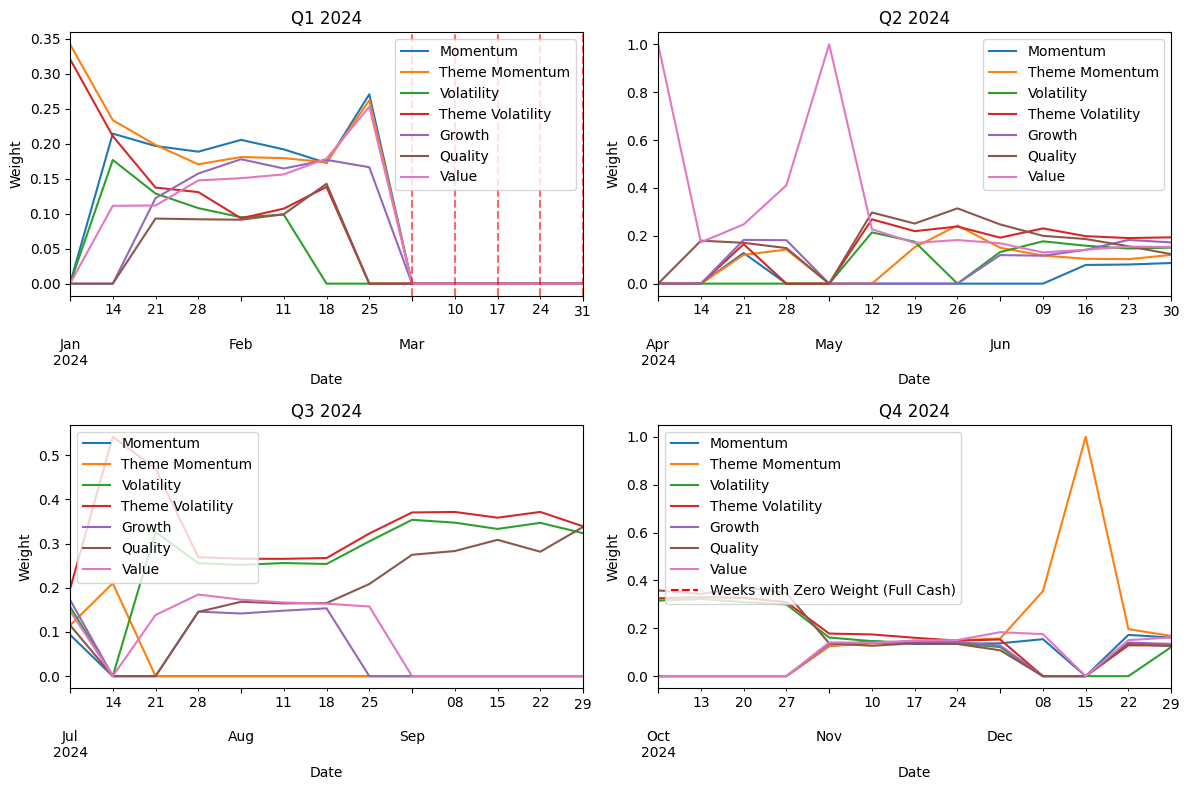

In [46]:
# Define last date and filter for last 2 years
last_date = all_weights_df.index.max()
start_date = last_date - pd.DateOffset(years=2)
all_weights_4y = all_weights_df[all_weights_df.index >= start_date]

# Resample to weekly
all_weights_weekly = all_weights_4y.resample('W').median()

# Filter for CY 2024
all_weights_2024 = all_weights_weekly[all_weights_weekly.index.year == 2024]

# Identify zero-weight weeks
zero_days = all_weights_2024[(all_weights_2024 == 0).all(axis=1)].index

# Split data into four quarters
quarters = {
    "Q1 2024": all_weights_2024.loc["2024-01-01":"2024-03-31"],
    "Q2 2024": all_weights_2024.loc["2024-04-01":"2024-06-30"],
    "Q3 2024": all_weights_2024.loc["2024-07-01":"2024-09-30"],
    "Q4 2024": all_weights_2024.loc["2024-10-01":"2024-12-31"],
}

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Flatten to make indexing easier

for i, (quarter, df) in enumerate(quarters.items()):
    ax = axes[i]
    
    # Plot weights
    df.plot(ax=ax, title=quarter)

    # Add vertical red dotted lines for zero-weight weeks
    for day in zero_days:
        if day in df.index:
            ax.axvline(day, color='red', linestyle='--', alpha=0.6)

    ax.set_ylabel('Weight')

# Add a single legend for cash weeks in the last subplot
axes[3].plot([], [], 'r--', label="Weeks with Zero Weight (Full Cash)")
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

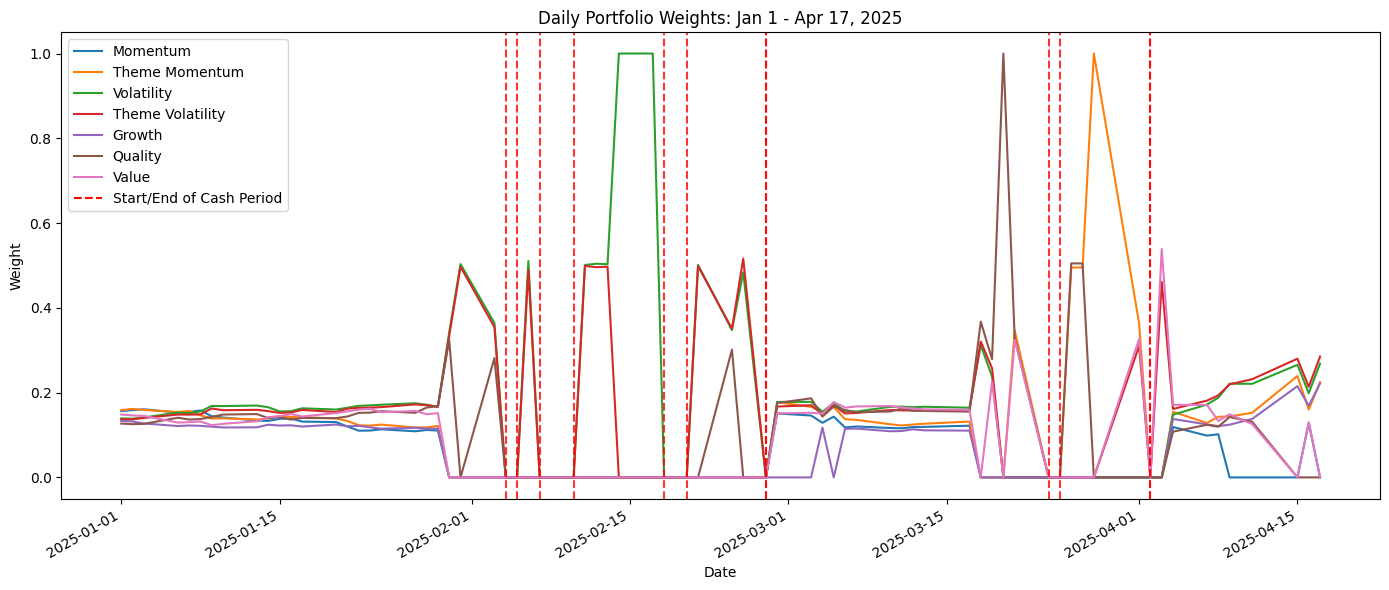

In [47]:
# Define date range
start_plot_date = pd.to_datetime("2025-01-01")
end_plot_date = pd.to_datetime("2025-04-17")

# Filter for the desired date range (daily data)
all_weights_2025_q1 = all_weights_df[(all_weights_df.index >= start_plot_date) & 
                                     (all_weights_df.index <= end_plot_date)]

# Identify cash days (all weights are zero)
is_cash_day = (all_weights_2025_q1 == 0).all(axis=1)

# Find start and end of cash periods
cash_periods = []
in_cash = False
for date, is_zero in is_cash_day.items():
    if is_zero and not in_cash:
        start_cash = date
        in_cash = True
    elif not is_zero and in_cash:
        end_cash = prev_date
        cash_periods.append((start_cash, end_cash))
        in_cash = False
    prev_date = date

# Handle if still in cash at end of date range
if in_cash:
    cash_periods.append((start_cash, prev_date))

# Plot
plt.figure(figsize=(14, 6))
ax = plt.gca()

# Plot weights
all_weights_2025_q1.plot(ax=ax, title="Daily Portfolio Weights: Jan 1 - Apr 17, 2025")

# Plot red vertical lines at start and end of each cash period
for start_cash, end_cash in cash_periods:
    ax.axvline(start_cash, color='red', linestyle='--', alpha=0.8)
    ax.axvline(end_cash, color='red', linestyle='--', alpha=0.8)

# Add legend for cash periods
ax.plot([], [], 'r--', label="Start/End of Cash Period")
ax.legend(loc='upper left')

plt.ylabel('Weight')
plt.tight_layout()
plt.show()


In [48]:
all_weights_df.tail(9)

,Momentum,Theme Momentum,Volatility,Theme Volatility,Growth,Quality,Value
Date,,,,,,,
2025-04-03,0.000000,0.000000,0.000000,0.461065,0.000000,0.000000,0.538935
2025-04-04,0.118790,0.154810,0.147831,0.161493,0.137844,0.107932,0.171300
2025-04-07,0.098576,0.128435,0.171795,0.181152,0.124984,0.124126,0.170932
2025-04-08,0.101741,0.143099,0.188096,0.193382,0.120912,0.119542,0.133228
2025-04-09,0.000000,0.143639,0.221037,0.219558,0.124328,0.142565,0.148875
2025-04-11,0.000000,0.152512,0.220843,0.231708,0.137969,0.131221,0.125746
2025-04-15,0.000000,0.239195,0.265611,0.280026,0.215167,0.000000,0.000000
2025-04-16,0.128752,0.159955,0.198627,0.213765,0.168947,0.000000,0.129954
2025-04-17,0.000000,0.224607,0.268644,0.285065,0.221685,0.000000,0.000000


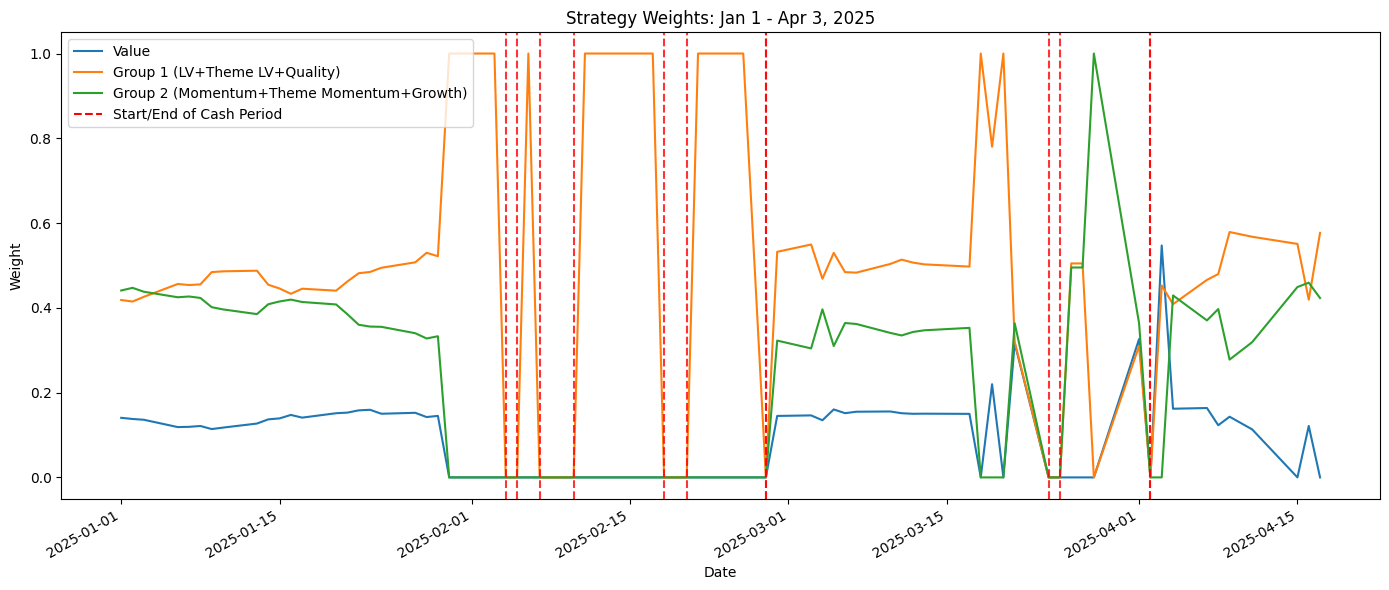

In [49]:
# Define date range
start_plot_date = pd.to_datetime("2025-01-01")
end_plot_date = pd.to_datetime("2025-04-17")

# Filter for the desired date range
weights_q1 = max_weights_df.loc[start_plot_date:end_plot_date]

# Define component groups
group_1_cols = ['Volatility', 'Theme Volatility', 'Quality']
group_2_cols = ['Momentum', 'Theme Momentum', 'Growth']
value_col = 'Value'  # standalone

# Create a new DataFrame with the three combined strategies
plot_df = pd.DataFrame(index=weights_q1.index)
plot_df['Value'] = weights_q1[value_col]
plot_df['Group 1 (LV+Theme LV+Quality)'] = weights_q1[group_1_cols].sum(axis=1)
plot_df['Group 2 (Momentum+Theme Momentum+Growth)'] = weights_q1[group_2_cols].sum(axis=1)

# Identify full cash days (all weights are zero across the original set)
is_cash_day = (weights_q1 == 0).all(axis=1)

# Detect cash period start/end
cash_periods = []
in_cash = False
prev_date = None
for date, is_zero in is_cash_day.items():
    if is_zero and not in_cash:
        start_cash = date
        in_cash = True
    elif not is_zero and in_cash:
        end_cash = prev_date
        cash_periods.append((start_cash, end_cash))
        in_cash = False
    prev_date = date
if in_cash:
    cash_periods.append((start_cash, prev_date))

# Plot
plt.figure(figsize=(14, 6))
ax = plt.gca()

# Plot combined strategy weights
plot_df.plot(ax=ax, title="Strategy Weights: Jan 1 - Apr 3, 2025")

# Red vertical lines at start/end of cash periods
for start_cash, end_cash in cash_periods:
    ax.axvline(start_cash, color='red', linestyle='--', alpha=0.8)
    ax.axvline(end_cash, color='red', linestyle='--', alpha=0.8)

# Add legend for cash periodsa
ax.plot([], [], 'r--', label="Start/End of Cash Period")
ax.legend(loc='upper left')

plt.ylabel("Weight")
plt.tight_layout()
plt.show()

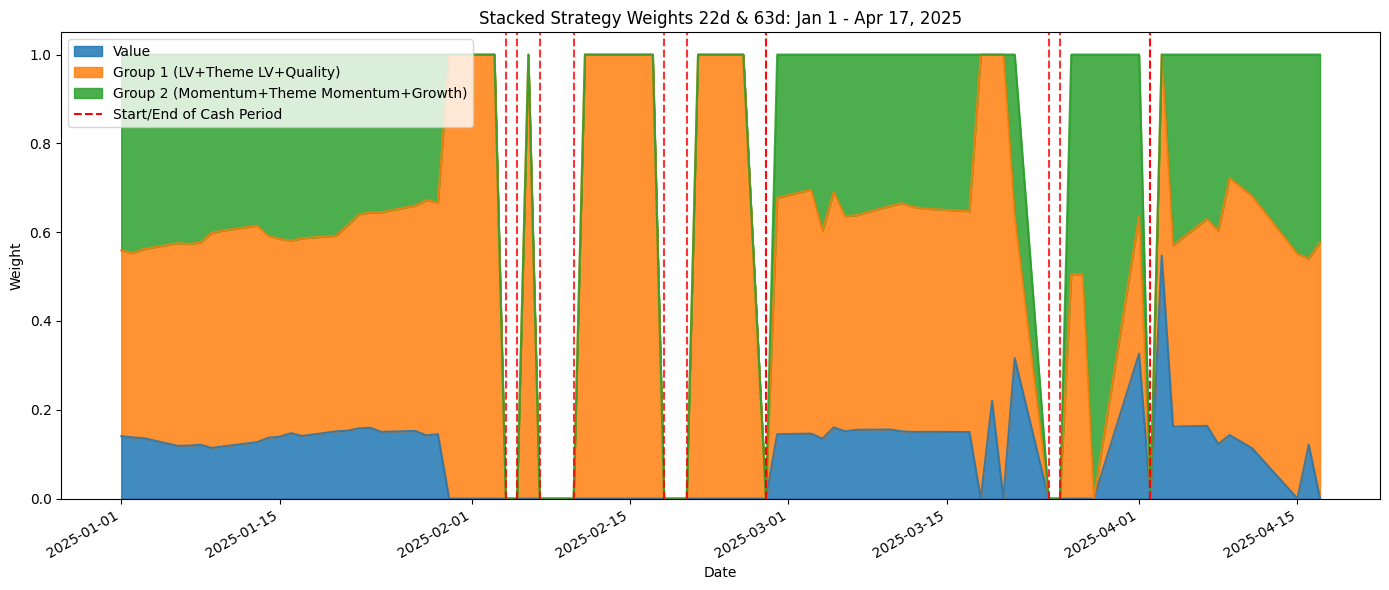

In [50]:
# Plot (Stacked Area Chart)
plt.figure(figsize=(14, 6))
ax = plt.gca()

# Plot stacked area chart
plot_df.plot.area(ax=ax, title="Stacked Strategy Weights 22d & 63d: Jan 1 - Apr 17, 2025", alpha=0.85)

# Red vertical lines at start/end of cash periods
for start_cash, end_cash in cash_periods:
    ax.axvline(start_cash, color='red', linestyle='--', alpha=0.8)
    ax.axvline(end_cash, color='red', linestyle='--', alpha=0.8)

# Add legend entry for cash lines
ax.plot([], [], 'r--', label="Start/End of Cash Period")
ax.legend(loc='upper left')

plt.ylabel("Weight")
plt.tight_layout()
plt.show()


In [51]:
all_weights_df.to_csv('2263.csv')

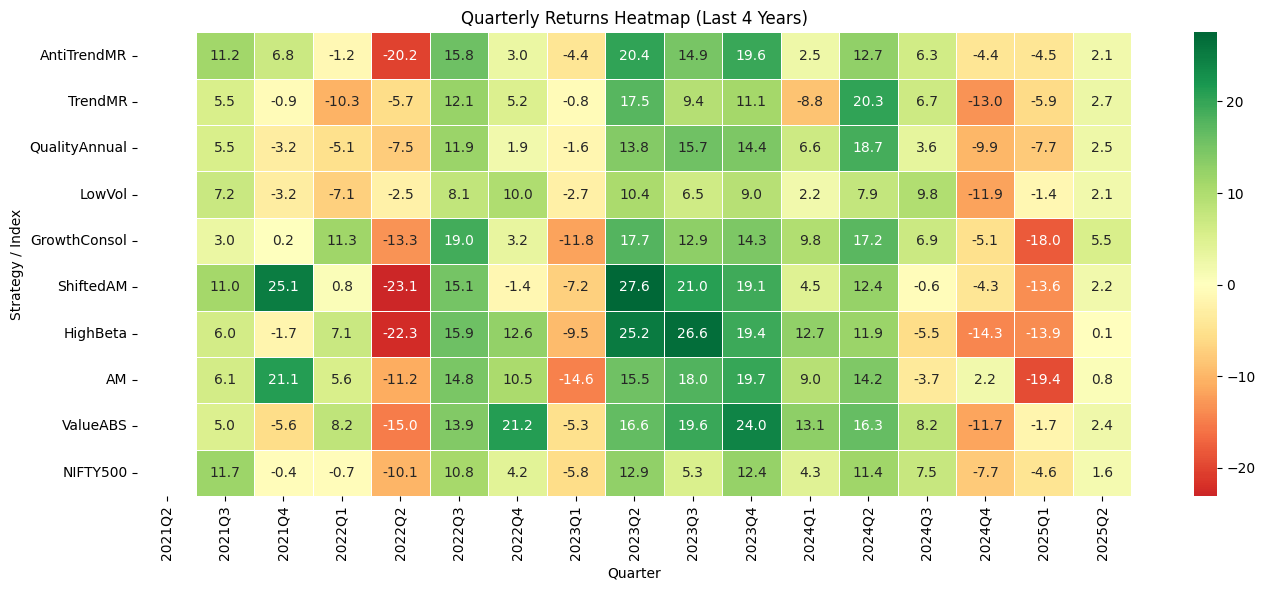

In [ ]:
# cols_to_plot = [
#     'AntiTrendMR', 'TrendMR', 'QualityAnnual', 'LowVol', 'GrowthConsol', 
#     'ShiftedAM', 'HighBeta', 'AM', 'ValueABS', 'NIFTY500'
# ]
# # Make sure your DataFrame index is datetime
# merged_df.index = pd.to_datetime(merged_df.index)

# # Select only the last 4 years of data
# last_4_years_df = merged_df.loc[merged_df.index >= (merged_df.index.max() - pd.DateOffset(years=4))]

# # Calculate quarterly returns: resample by quarter end and compute % return
# quarterly_prices = last_4_years_df[cols_to_plot].resample('Q').last()
# quarterly_returns = quarterly_prices.pct_change() * 100  # percent returns

# # Format index to "YYYY-QX"
# quarterly_returns.index = quarterly_returns.index.to_period('Q').astype(str)

# # Create heatmap
# plt.figure(figsize=(14, 6))
# sns.heatmap(quarterly_returns.T, annot=True, fmt=".1f", cmap='RdYlGn', center=0, linewidths=0.5)
# plt.title("Quarterly Returns Heatmap (Last 4 Years)")
# plt.xlabel("Quarter")
# plt.ylabel("Strategy / Index")
# plt.tight_layout()
# plt.show()


In [91]:
# Synthetic Factor 1: "HighBeta Combo"
highbeta_combo = ['HighBeta', 'ShiftedAM', 'ValueABS', 'AntiTrendMR']

# Synthetic Factor 2: "EqualWeight Combo"
eqweight_combo = ['ShiftedAM', 'ValueABS', 'AntiTrendMR']

# Calculate daily returns for all columns
daily_returns = merged_df.pct_change()

# Drop initial NaNs
daily_returns = daily_returns.dropna()

# Synthetic factor returns: average of component returns
highbeta_nav_ret = daily_returns[highbeta_combo].mean(axis=1)
eqweight_nav_ret = daily_returns[eqweight_combo].mean(axis=1)

# Rebase to NAV series starting at 100
highbeta_nav = (1 + highbeta_nav_ret).cumprod() * 100
eqweight_nav = (1 + eqweight_nav_ret).cumprod() * 100

merged_df['HIGHBETA_SYNTH'] = highbeta_nav
merged_df['EQWEIGHT_SYNTH'] = eqweight_nav

In [101]:
# Clip returns to a lower bound (e.g., -99%)
clean_returns = daily_returns[highbeta_combo + eqweight_combo].clip(lower=-0.99)
highbeta_nav_ret = clean_returns[highbeta_combo].mean(axis=1)
eqweight_nav_ret = clean_returns[eqweight_combo].mean(axis=1)

highbeta_nav = (1 + highbeta_nav_ret).cumprod() * 100
eqweight_nav = (1 + eqweight_nav_ret).cumprod() * 100

merged_df['HIGHBETA_SYNTH'] = highbeta_nav.reindex(merged_df.index).ffill()
merged_df['EQWEIGHT_SYNTH'] = eqweight_nav.reindex(merged_df.index).ffill()


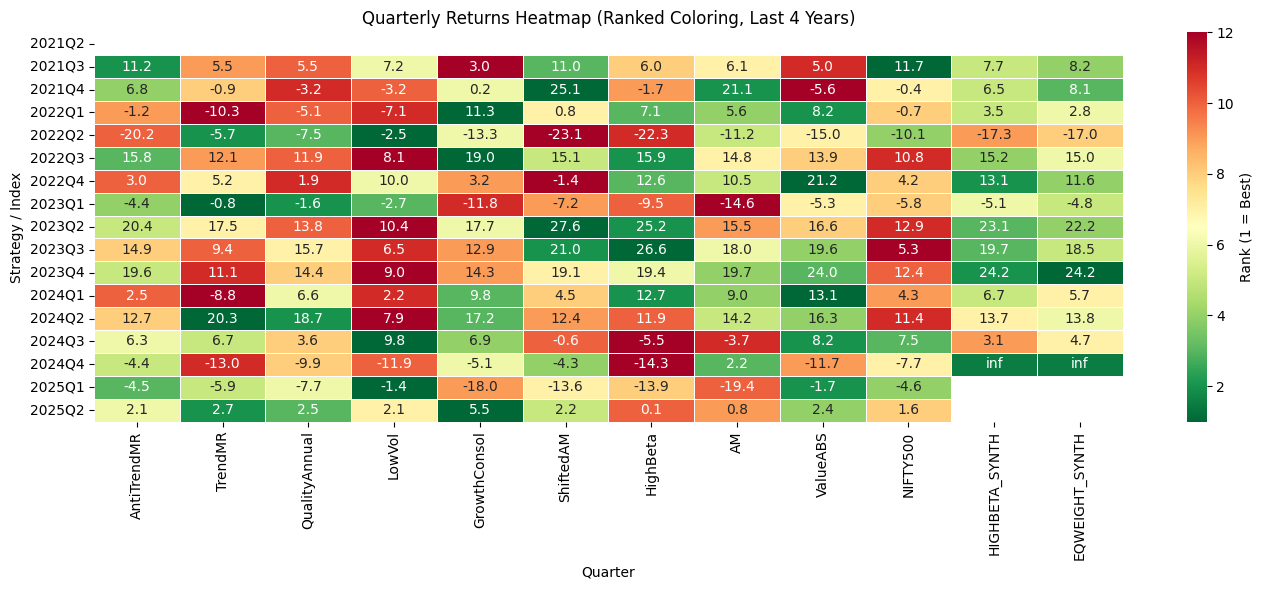

In [102]:
cols_to_plot = [
    'AntiTrendMR', 'TrendMR', 'QualityAnnual', 'LowVol', 'GrowthConsol', 
    'ShiftedAM', 'HighBeta', 'AM', 'ValueABS', 'NIFTY500',
    'HIGHBETA_SYNTH', 'EQWEIGHT_SYNTH'
]


# Ensure datetime index
merged_df.index = pd.to_datetime(merged_df.index)

# Filter last 4 years
last_4_years_df = merged_df.loc[merged_df.index >= (merged_df.index.max() - pd.DateOffset(years=4))]

# Resample and compute returns
quarterly_prices = last_4_years_df[cols_to_plot].resample('Q').last()
quarterly_returns = quarterly_prices.pct_change() * 100

# Format index to "YYYY-QX"
quarterly_returns.index = quarterly_returns.index.to_period('Q').astype(str)

# Compute ranks per quarter (1 = best return)
ranks = quarterly_returns.rank(ascending=False, axis=1)
ranks.index = quarterly_returns.index  # Ensure formatted index carries over

# Plot
plt.figure(figsize=(14, 6))
sns.heatmap(
    ranks,
    annot=quarterly_returns.round(1),  # Show actual return values
    fmt=".1f",
    cmap='RdYlGn_r',  # Reverse so 1 = best (green), higher = worse (red)
    cbar_kws={'label': 'Rank (1 = Best)'},
    linewidths=0.5
)

plt.title("Quarterly Returns Heatmap (Ranked Coloring, Last 4 Years)")
plt.xlabel("Quarter")
plt.ylabel("Strategy / Index")
plt.tight_layout()
plt.show()

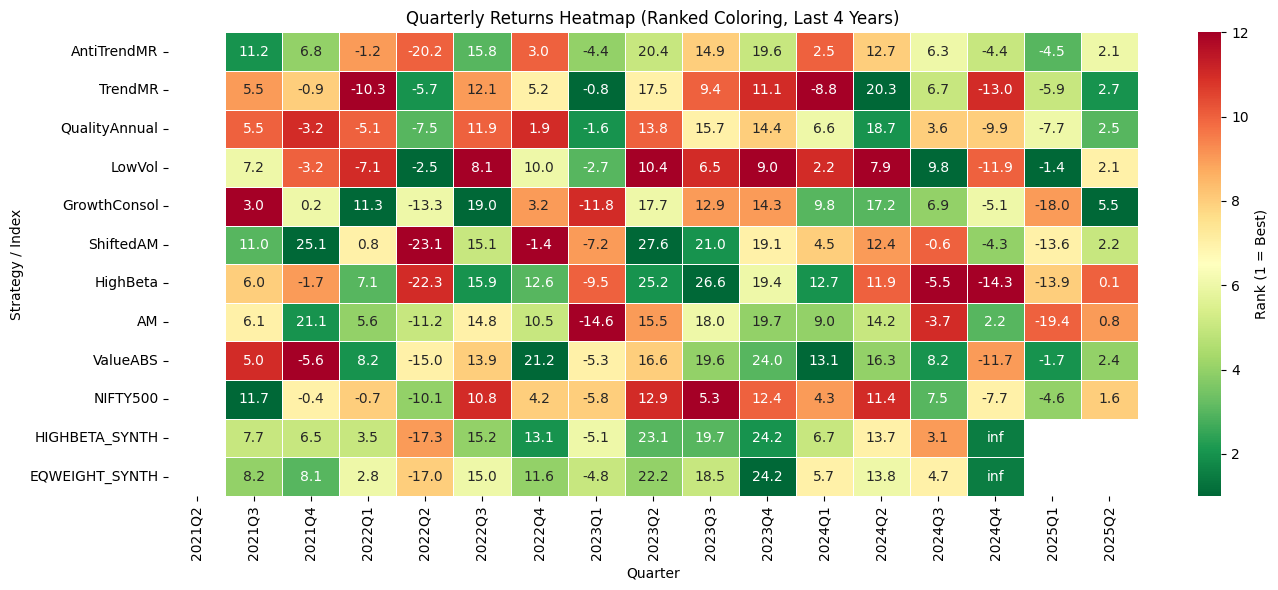

In [103]:
cols_to_plot = [
    'AntiTrendMR', 'TrendMR', 'QualityAnnual', 'LowVol', 'GrowthConsol', 
    'ShiftedAM', 'HighBeta', 'AM', 'ValueABS', 'NIFTY500',
    'HIGHBETA_SYNTH', 'EQWEIGHT_SYNTH'
]

# Ensure datetime index
merged_df.index = pd.to_datetime(merged_df.index)

# Filter last 4 years
last_4_years_df = merged_df.loc[merged_df.index >= (merged_df.index.max() - pd.DateOffset(years=4))]

# Resample and compute quarterly returns
quarterly_prices = last_4_years_df[cols_to_plot].resample('Q').last()
quarterly_returns = quarterly_prices.pct_change() * 100

# Format index to "YYYY-QX"
quarterly_returns.index = quarterly_returns.index.to_period('Q').astype(str)

# Compute ranks per quarter (1 = best return)
ranks = quarterly_returns.rank(ascending=False, axis=1)
ranks.index = quarterly_returns.index  # Ensure same index format

# Plot: transpose so quarters are on X-axis
plt.figure(figsize=(14, 6))
sns.heatmap(
    ranks.T,  # transpose to put time on x-axis
    annot=quarterly_returns.T.round(1),  # also transpose returns
    fmt=".1f",
    cmap='RdYlGn_r',  # reversed so 1 = best (green)
    cbar_kws={'label': 'Rank (1 = Best)'},
    linewidths=0.5
)

plt.title("Quarterly Returns Heatmap (Ranked Coloring, Last 4 Years)")
plt.xlabel("Quarter")
plt.ylabel("Strategy / Index")
plt.tight_layout()
plt.show()

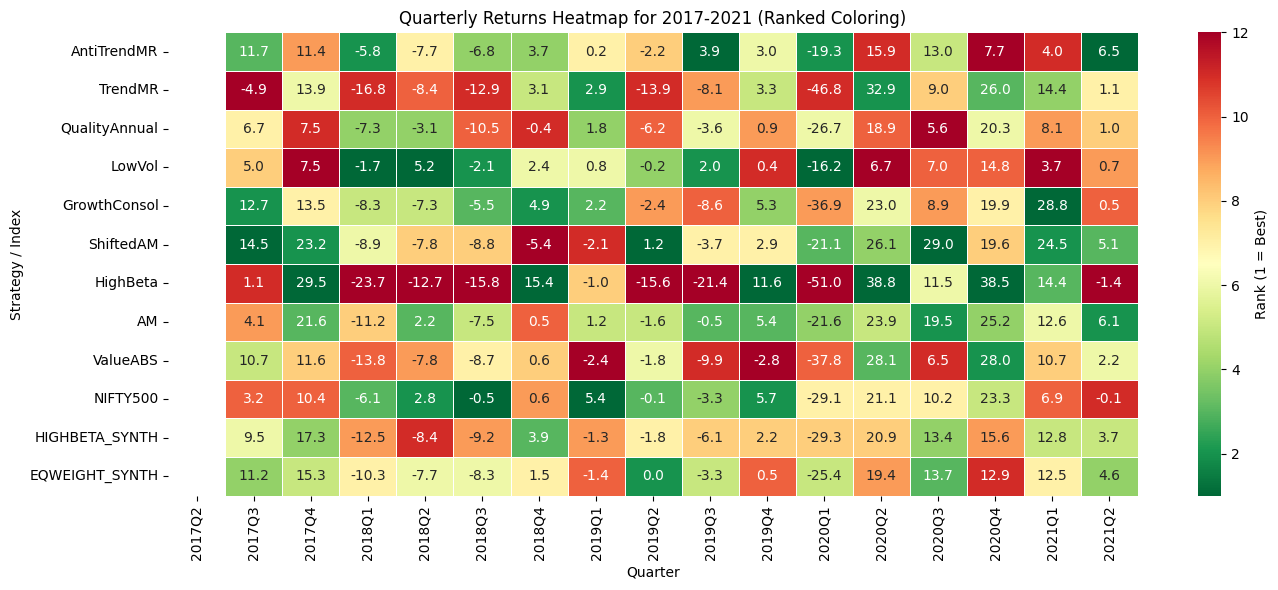

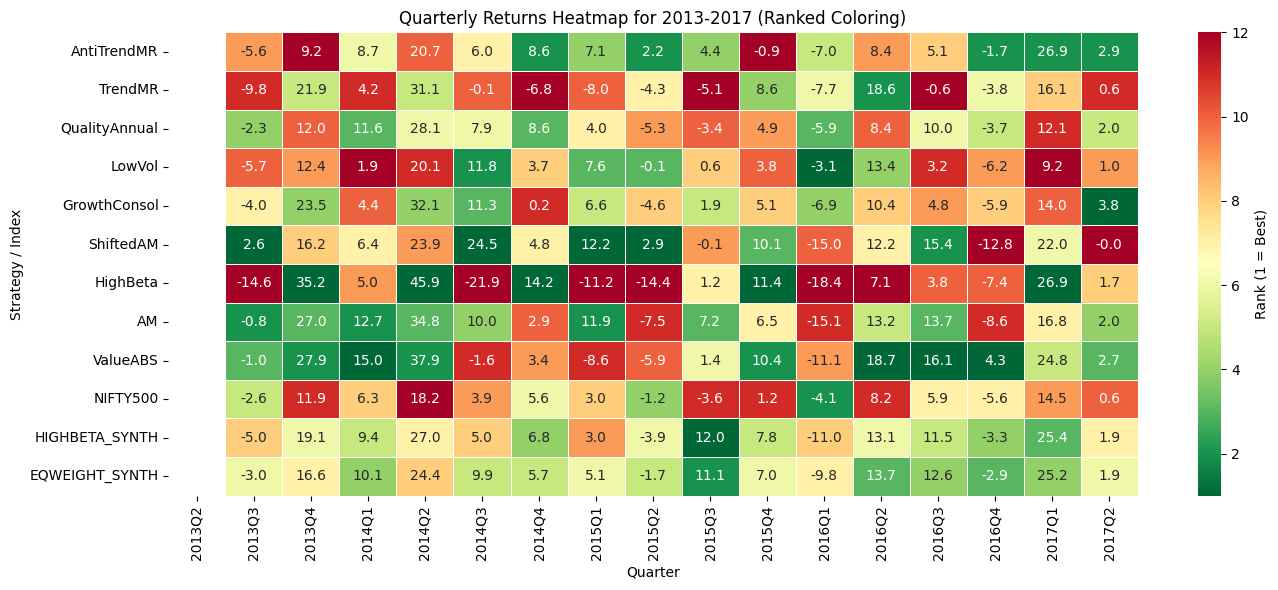

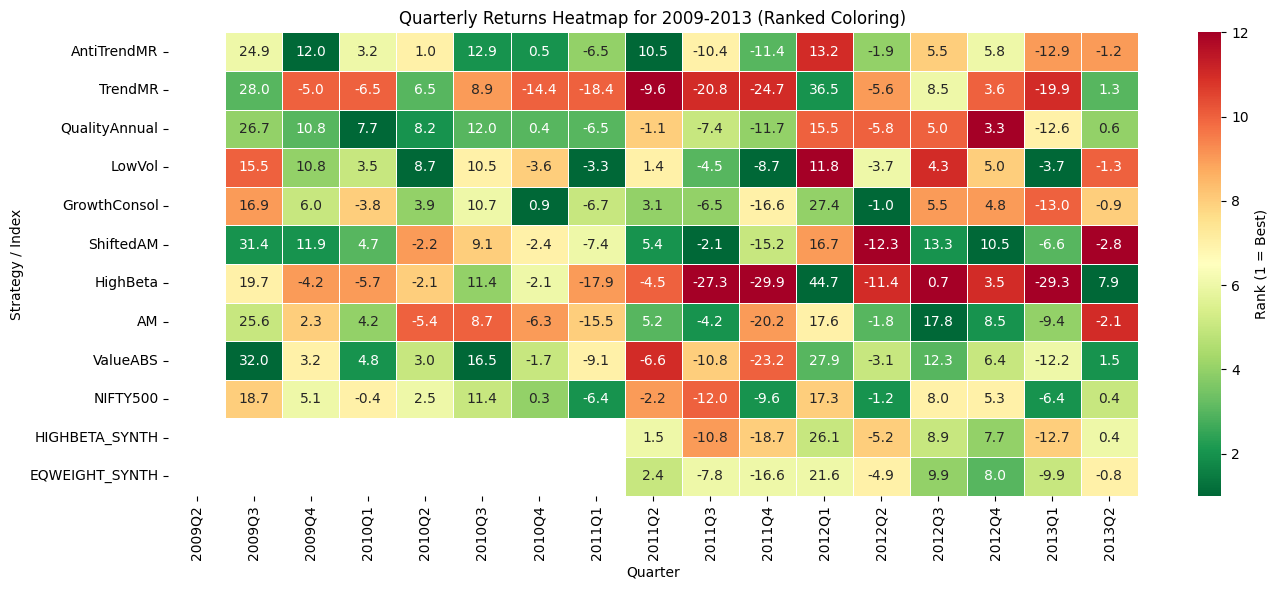

In [104]:
# Ensure datetime index
merged_df.index = pd.to_datetime(merged_df.index)

# Define the latest date in the dataset
latest_date = merged_df.index.max()

# Loop through each 4-year period before the last 4 years
start_date = latest_date - pd.DateOffset(years=8)  # 8 years ago, 4 years before the last period
while start_date >= merged_df.index.min():
    # Filter data for this 4-year period
    end_date = start_date + pd.DateOffset(years=4)
    period_df = merged_df.loc[(merged_df.index >= start_date) & (merged_df.index < end_date)]

    # Resample and compute quarterly returns
    quarterly_prices = period_df[cols_to_plot].resample('Q').last()
    quarterly_returns = quarterly_prices.pct_change() * 100

    # Format index to "YYYY-QX"
    quarterly_returns.index = quarterly_returns.index.to_period('Q').astype(str)

    # Compute ranks per quarter (1 = best return)
    ranks = quarterly_returns.rank(ascending=False, axis=1)
    ranks.index = quarterly_returns.index  # Ensure same index format

    # Plot: transpose so quarters are on X-axis
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        ranks.T,  # transpose to put time on x-axis
        annot=quarterly_returns.T.round(1),  # also transpose returns
        fmt=".1f",
        cmap='RdYlGn_r',  # reversed so 1 = best (green)
        cbar_kws={'label': 'Rank (1 = Best)'},
        linewidths=0.5
    )

    plt.title(f"Quarterly Returns Heatmap for {start_date.year}-{end_date.year} (Ranked Coloring)")
    plt.xlabel("Quarter")
    plt.ylabel("Strategy / Index")
    plt.tight_layout()
    plt.show()

    # Move to the next 4-year period (go backwards)
    start_date -= pd.DateOffset(years=4)

In [88]:
# Create an empty PDF to save all the plots
with PdfPages('rolling_correlation_plots.pdf') as pdf:
    for strategy1 in set1:
        for strategy2 in set2:
            # Create a temporary dataframe just for the two strategies we're analyzing
            temp_df = daily_returns[[strategy1, strategy2]].copy()
            
            # Calculate rolling correlation with 252-day window (approximately 1 trading year)
            correlation_series = temp_df[strategy1].rolling(window=252).corr(temp_df[strategy2])
            
            # Drop last 10 values from the correlation series
            correlation_series = correlation_series.iloc[:-10]

            # Create a clean dataframe for plotting
            corr_df = pd.DataFrame({f'{strategy1} vs {strategy2}': correlation_series}, index=temp_df.index[:-10])
            
            # Plot the rolling correlation
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=corr_df)
            
            # Format the x-axis with proper date handling
            plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
            plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(2))  # Show tick every 2 years
            
            plt.title(f"1-Year Rolling Correlation: {strategy1} vs {strategy2}")
            plt.xlabel("Date")
            plt.ylabel("Correlation")
            plt.grid(True, alpha=0.3)
            
            # Add a horizontal line at zero for reference
            plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
            
            plt.tight_layout()
            
            # Save the current plot to the PDF
            pdf.savefig()
            plt.close()


In [89]:
merged_df

,ThemeGrowthConsol,SectorAM,UltraShortAM,ValueYieldNoPeg,QualityAnnual,LowVol,LongAM,SectorHighBeta,ThemeLTMA,SectorAvgVol,...,SectorValueABS,LowBeta,ShortAM,HighBeta,ValueABSNoPeg,MidAM,ThemeValueABS,ThemeMidAM,ThemeLowBeta,NIFTY500
Date,,,,,,,,,,,,,,,,,,,,,
2006-06-21,100.000000,100.000000,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2442.95
2006-06-22,101.041369,100.879686,100.759384,101.062911,NaN,100.818947,100.824060,100.897251,100.561649,100.509831,...,100.807031,100.492394,100.383904,101.450678,101.051661,100.772123,101.232319,100.672038,100.614594,2503.50
2006-06-23,100.937931,102.193023,100.973535,101.538819,NaN,100.734853,101.360807,101.953130,101.205667,100.621593,...,102.035122,100.989835,100.470351,103.085694,101.123905,101.683206,101.005827,101.545761,100.596866,2529.45
2006-06-26,97.673064,98.314515,97.878136,97.628736,NaN,99.141758,97.771204,97.983265,97.667249,97.576523,...,98.652175,99.759165,97.196498,97.926130,97.178746,96.929551,96.628121,98.523656,99.055929,2441.20
2006-06-27,95.996067,99.107271,97.610868,97.057619,NaN,98.749072,96.101243,98.254847,97.665272,96.743069,...,98.811609,98.684812,96.380434,97.605600,96.014975,96.416215,95.886267,97.571662,98.526242,2456.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-09,843.078775,3720.003322,1452.493190,1261.156126,703.074840,809.235743,2552.287512,595.296839,1172.763245,1029.912680,...,630.354971,277.717061,2083.091435,108.547169,1105.864366,2120.328553,1018.536528,3410.439331,961.081490,20356.75
2025-04-11,862.869740,3796.886935,1493.765930,1288.049557,716.241276,816.496473,2669.390571,611.647069,1199.659881,1048.029773,...,638.462029,280.978950,2123.089797,110.600970,1124.454222,2188.602809,1029.767622,3467.567082,967.602356,20752.85
2025-04-15,893.250838,3918.726310,1544.817301,1325.690194,734.763722,831.920956,2767.217618,631.975642,1243.527393,1073.059443,...,652.012391,286.665515,2182.786125,115.324263,1159.170511,2254.863848,1047.420690,3590.045246,979.238536,21279.40


In [ ]:
print(daily_returns.index.min())  # Start date of your returns data
print(correlation_series.first_valid_index())  # First date with a valid rolling correlation

2011-02-24 00:00:00
2012-03-14 00:00:00
